# Predicting Star Ratings of Edinburgh Airbnbs through Review Texts Analysis

# Notebook 5: Modelling_Review_Collapsed

# Introduction

In this notebook, we will analyze our review dataset using another pre-defined format: **all reviews corresponding to the same listing will be condensed into one block of text and aggregated with their corresponding listing information and overall rating sentiment score**.

The reason for us to perform this transformation is that since we do not obtain star rating scores for every review, we used the average review score for each Airbnb listing and defined our sentiment threshold. Therefore, our analysis should have better interpretability if we use the **condensed reviews** to predict averaged rating scores. This means that we will obtain a dataset with **fewer data points** compared to the dataset we used in the previous notebook, as each row represents one Edinburgh Airbnb listing. This might affect our model performance, but hopefully it will allow us to extract more insightful word features.

Our analysis will be presented in the following steps:

- Import pre-defined functions from previous notebooks. For more specific information about these functions, please view **'my_function.py'**.
- Model setup including splitting variables and performing train-test-split stages.
- Obtain baseline model performance.
- Perform two grid searches following the procedure from the previous notebook.
- Perform primary evaluations

***

# Table of Contents

1. [**Import Libraries**](#a1)<br>
    
2. [**Modelling Set Up**](#a2)<br>
    2.1.[Split Variables](#a2.1)<br>
    2.2.[Train Test Split](#a2.2)<br>
    
3. [**Baseline Model**](#a3)<br>
    3.1.[Baseline Model Evaluation](#a3.1)<br>
4. [**Modelling**](#a4)<br>
    4.1.[GridSearch_1: General Sweep](#a4.1)<br>
    4.2 [GridSearch_2: Ngrams](#a4.2)<br>
5. [**Summary**](#a6)<br>

***

## Import Libraries <a id='a1'></a>

In [1]:
# Main Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scipy Library for sparse  matrix
from scipy.sparse import csr_matrix

# NLP Libraries
import nltk
import re
import string
import html
import contractions
import langid
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from langid.langid import LanguageIdentifier

# Download from nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Feature Extraction Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Dummy Classifer 
from sklearn.dummy import DummyClassifier

# Modelling Libraries
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Evaluation Libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import joblib
import pickle as pk

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Import functions from local

In [99]:
%run -i my_function.py

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Loading Relevant Data

In [3]:
# Load collapsed review data
df_collapsed_reviews_by_listing= joblib.load('data/df_collapsed_reviews_by_listing.pkl')

#### Ignore userwarnings

In [4]:
import warnings

# Ignore UserWarning
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

#### Check the uncollapsed review data shape

In [5]:
print(f'The dataset contains all reviews listed individually is of dimension {df_collapsed_reviews_by_listing.shape}')

The dataset contains all reviews listed individually is of dimension (5908, 45)


***

# Modelling Set up <a id='a3'></a>

## Split the variables <a id='a3.1'></a>

We need to split the variables into dependent and independent variables before we start fitting the model. The target variable will be the sentiment scores. We will focus on the overall sentiment score and attempt to further analyse the reviews with the other sub-rating transformed sentiment scores.

In [6]:
# Define X and y for the future model
X = df_collapsed_reviews_by_listing.drop(['Overall_sentiment',
                                          'accuracy_sentiment',
                                          'cleanliness_sentiment',
                                          'checkin_sentiment',
                                          'communication_sentiment',
                                          'location_sentiment',
                                          'value_sentiment'], axis=1)
y = df_collapsed_reviews_by_listing['Overall_sentiment']

In [7]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (5908, 38)
y Shape: (5908,)


The dependent variable stored as **X** contains all cleaned listing related numerical data as well as a column that contains the guest review data.

The independent variable stored as **y** contains the **Overall sentiment score** that was transformed from the listing's average overall rating score:
- 1 was denoted by Overall rating score > 4.8
- 0 was denoted by Overall rating score < 4.8

We can see that the current dataset only contains about **6000** rows, this number corresponds to the number of Airbnb listings in Edinburgh which has at least three reviews contained in our initial dataset.

***

## Train Test Split <a id='a3.4'></a>

The modelling process starts by splitting our dataset into training and testing sets. This procedure is fundamental for the effective evaluation of our model performance.

The training data is implemented upon which our model is built and refined, and the testing data provides the benchmark for assessing the model's predictive performance on unseen data. This ensures us to mitigate the risk of **overfitting**, as our model will not just memorize the data pattern but rather learns to generalize on new, unseen data.

Additionally, it is important that this splitting process must precede any data transformation steps including random sampling, text vectorization and scaling to prevent potential **data leakage**.

In [47]:
# Split test data as 30% of all data, determine random state to make sure every split is the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Show the number of rows for training and testing dataset
print(f'The number of rows obtained in the training data is {X_train.shape[0]}, with {X_train.shape[1]} feature columns.')
print(f'The number of rows obtained in the testing data is {X_test.shape[0]}, with {X_train.shape[1]} feature columns.')

The number of rows obtained in the training data is 4726, with 38 feature columns.
The number of rows obtained in the testing data is 1182, with 38 feature columns.


***

# Baseline Model <a id='a4'></a>

As we are developing the best performed models for predicting the class of guest sentiments, it is crucial to establish a baseline model for comparison. We will utilise a **Dummy Classifier** model, which makes predictions without accessing dataset features, essentially performing random guessing. By establishing this baseline, we can decide that any model performing worse than the baseline model will not proceed to further analysis. 

**Run Time**: 1mins 30s

In [12]:
# Vectorize data using Bag of Words Vectorizer
bow_vec = CountVectorizer(max_features = 500, # Only obtain top 500 features based on vectorizer results
                            min_df=5, # Feature occurency should be bigger than 5 in the corpus
                            tokenizer=customized_tokenizer)

# Fit and transform on the vectorizer to training data
X_train_bow_d = bow_vec.fit_transform(X_train['comments']).toarray()

# Transform on both training data and testing data
X_test_bow_d = bow_vec.transform(X_test['comments']).toarray()

# Reset Index before concatenating
X_train_reset_index = X_train.reset_index(drop=True)
X_test_reset_index = X_test.reset_index(drop=True)

# Merge the resulting arrays with the original numeric features
X_train_bow_d_transformed = pd.concat([X_train_reset_index.drop(['comments'], axis=1),
                                         pd.DataFrame(X_train_bow_d, columns=[i for i in bow_vec.get_feature_names_out()])], axis=1)

X_test_bow_d_transformed = pd.concat([X_test_reset_index.drop(['comments'], axis=1), 
                                        pd.DataFrame(X_test_bow_d, columns=[i for i in bow_vec.get_feature_names_out()])], axis = 1)

# Print shape of the vectorized training feature data
print(f'X_train_transfomed_dummy : {X_train_bow_d_transformed.shape}')

X_train_transfomed_dummy : (4726, 537)


In [50]:
# # Dummy Classifier - Baseline Model
# Instantiate Dummy Classifier
dummy_classifier = DummyClassifier()

# Fit the Dummy Classifier on Training data
dummy_classifier.fit(X_train_bow_d_transformed, y_train)

# Predict the fitted model on Testing Data
y_predict_d = dummy_classifier.predict(X_test_bow_d_transformed)

# Print F1 score
print(f'The F1 Score (%) for the Baseline Model is: {round(f1_score(y_test, y_predict_d)*100, 2)} %')

The F1 Score (%) for the Baseline Model is: 73.45 %


#### Classification report <a id='a4.1'></a>

In [49]:
# Generate classification report to see specific classification evaluation metrics scores
baseline_report = classification_report(y_test, y_predict_d)
print(baseline_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       496
           1       0.58      1.00      0.73       686

    accuracy                           0.58      1182
   macro avg       0.29      0.50      0.37      1182
weighted avg       0.34      0.58      0.43      1182



***

# Modelling <a id='a5'></a>

After completing data cleaning, pre-processing, and model setup stages, we are ready to train models and make predictions. To determine the best-performing model, we will utilize **GridSearchCV** to find the optimal model with the best hyperparameters. Machine learning metrics and models to be used in our modeling process include:

- Text Vectorizer: Bag of Words, TF-IDF
- Scaler: StandardScaler
- Models: Logistic Regression, Decision Tree Classifier, Random Forest Classifier.

Note that for performance purposes, we will be vectorizing the datasets outside of grid search. We will then fit combinations of models to the training data that has been transformed by two types of text vectorizations. During the fitting process, **5-fold cross-validation** will be performed to improve model performance and interpretability. Finally, the model with the highest average validation F1 score will be selected and evaluated at the end of each GridSearch. 

## GridSearch_1: General Sweep <a id='a5.1'></a>

During the first GridSearch on this dataset, we will be searching for optimal hyperparameters over wide ranges implementing on the **Logistic Regresion** and **Decision Tree Classifier**. This GridSearch will be run and fitted on two vectorized training sets defined in the previous notebook and we will evaluate the model performances with a brief summary. The selections of models and parameters are summarized below:

|    Models   |    Hyperparameters   |   Ranges/Options  |
|:-------------:|:-------------:|:-------------:|
|    **TfidfVectorizer**     |     max_df   |    0.95     |
|                  |     min_df  |    5       |
|       **CountVectorizer**           |     max_df  |    0.95       |
|                  |     min_df  |    5       |
|    **Logistic Regression**     |    C     |    0.001, 0.01, 0.1, 1, 10    |
|         |    penalty     |    'none', 'l2'     | 
|    **Decision Tree Classifier**     |     max_depth    |     2, 8, 32, 64, 128    |
|                 |    min_samples_leaf     |     2, 4, 8    |
|                 |     min_samples_split    |     2, 4, 8    |
|                 |     criterion    |     'gini', 'entropy'    |

### First GridSearch
Run time: 1 hours 27 min 56s

To save long execution times for future references, we will use a loading flag to prevent re-training models when it is already saved and can be loaded as a pickle file

In [16]:
# # First GridSearch
#-----------------------------------------------------------------------------------------------------------------#
# Extract numerical column names for column transformer
numeric_columns = X.select_dtypes(exclude='object').columns.to_list()
# Define column transformers
ct_bow = define_col_trans('ct_bow',  CountVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer))
ct_tfidf = define_col_trans('ct_tfidf',  TfidfVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer))
#-----------------------------------------------------------------------------------------------------------------#
# Fit and transform on training data using two types of vectorizers
print('Transforming training sample data .....')
X_train_ct_bow = ct_bow.fit_transform(X_train)
X_train_ct_tfidf= ct_tfidf.fit_transform(X_train)
print('Training sample data transformed.')
#-----------------------------------------------------------------------------------------------------------------#

# If one needs to retrain the model, set loading flag as False
loaded_flag_1 = False

if loaded_flag_1:
    # Load saved fittedgrid
    fittedgrid_1_bow_collapsed=joblib.load('data/fittedgrid_1_bow_collapsed.pkl')
    fittedgrid_1_tfidf_collapsed=joblib.load('data/fittedgrid_1_tfidf_collapsed.pkl')
    print('Loaded pre-trained models (Gridsearch_1)')
else:
    # Define base pipeline
    pipeline_1 = Pipeline([
        ('sparse_to_dense', FunctionTransformer(convert_to_array, accept_sparse=True)),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])
    
    # Instantiate Pipeline with grid of parameters
    grid_param_1 = [

        # Logistic Regression
        {
            'model'              : [LogisticRegression()],
            'model__C'           : [0.001, 0.01, 0.1, 1, 10], # C parameter to control penalty weights
            'model__penalty'     : ['none', 'l2'], # Control penalty types, l1: Lasso, l2: Ridge
            'model__random_state': [123], # Control gradient descent starting point
            'model__max_iter'    : [10000] # Make sure model iterates
        },

        # Decision Tree Classifier
        {
            'model'                   : [DecisionTreeClassifier()],
            'model__max_depth'        : [2, 8, 32, 64, 128], # Control number of tree splits/depth
            'model__min_samples_leaf' : [2, 4, 8], # Control minimum number of samples at a leaf node
            'model__min_samples_split': [2, 4, 8], # Control minimum number of samples split at a leaf node
            'model__criterion'        : ['gini', 'entropy'], # Control the function to measure the quality of a split
            'model__random_state'     :[123] # Control randomness of the estimator
        }
    ]

    # Use GridSearch
    grid_1 = GridSearchCV(estimator=pipeline_1, # Define GridSearch estimator pipeline
                         param_grid=grid_param_1, # Define parameter grid
                         cv=5, # Define 5-fold cross-validation
                         n_jobs=-2,
                         scoring='f1') 

    # Fit the grid on training data
    fittedgrid_1_bow_collapsed = grid_1.fit(X_train_ct_bow, y_train)
    fittedgrid_1_tfidf_collapsed = grid_1.fit(X_train_ct_tfidf, y_train)
    
    # Save fittedgrid as pickle file
    joblib.dump(fittedgrid_1_bow_collapsed, 'data/fittedgrid_1_bow_collapsed.pkl')
    joblib.dump(fittedgrid_1_tfidf_collapsed, 'data/fittedgrid_1_tfidf_collapsed.pkl')

Transforming training sample data .....
Training sample data transformed.
Loaded pre-trained models (Gridsearch_1)


***

### First GridSearch Results

#### Selected model results with Bag of Words transformed data 

In [17]:
print('\n--------------------\n')
print(fittedgrid_1_bow_collapsed.best_estimator_)

# Print Crossvalidated Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_1_bow_collapsed.score(X_train_ct_bow, y_train)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')

# Vectorize on testing data to evaluate model actual performance
X_test_ct_bow = ct_bow.transform(X_test)
print(f'Best Model Test Score (%): {round(fittedgrid_1_bow_collapsed.score(X_test_ct_bow, y_test)*100, 2)}') 


--------------------

Pipeline(steps=[('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_array at 0x0000023E169A6340>)),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.001, max_iter=10000,
                                    random_state=123))])

--------------------

Best Model Train Score (%): 96.08

--------------------

Best Model Test Score (%): 86.75


#### Selected model results with TF-IDF transformed data 

In [51]:
print('\n--------------------\n')
print(fittedgrid_1_tfidf_collapsed.best_estimator_)

# Print Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_1_tfidf_collapsed.score(X_train_ct_tfidf, y_train)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')

# Vectorize on testing data to evaluate model actual performance
X_test_ct_tfidf = ct_tfidf.transform(X_test)
print(f'Best Model Test Score (%): {round(fittedgrid_1_tfidf_collapsed.score(X_test_ct_tfidf, y_test)*100, 2)}') 


--------------------

Pipeline(steps=[('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_array at 0x0000023E169A6340>)),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.001, max_iter=10000,
                                    random_state=123))])

--------------------

Best Model Train Score (%): 99.57

--------------------

Best Model Test Score (%): 85.16


#### Top 10 models with best F1 scores resulted with Bag of Words transformed data

In [55]:
# Expand column width to see full results
pd.set_option('display.max_colwidth', None)

# Store results in a dataframe by sorting mean_test_score in descending order
fittedgrid1_results_df = pd.DataFrame(fittedgrid_1_bow_collapsed.cv_results_).sort_values('mean_test_score', ascending=False)

# Extract ranking number, models with tuned hyperparameters, and corresponding test scores
fittedgrid1_results = fittedgrid1_results_df[['rank_test_score', 'params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)
print('GridSearch_1 Cross_Validation Results')

# Show top 10 cross validation results
fittedgrid1_results.head(10) 

GridSearch 1 Cross Validation Results


,rank_test_score,params,mean_test_score
1,1,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 0.001, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.835450
3,2,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 0.01, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.823902
5,3,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 0.1, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.817805
7,4,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 1, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.811765
9,5,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 10, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.810164
15,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 4, 'model__min_samples_split': 8, 'model__random_state': 123}",0.788766
10,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.788766
13,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__random_state': 123}",0.788766
11,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.788766
16,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 8, 'model__min_samples_split': 2, 'model__random_state': 123}",0.788766


#### GridSearch_1 Best Model Confusion Matrix

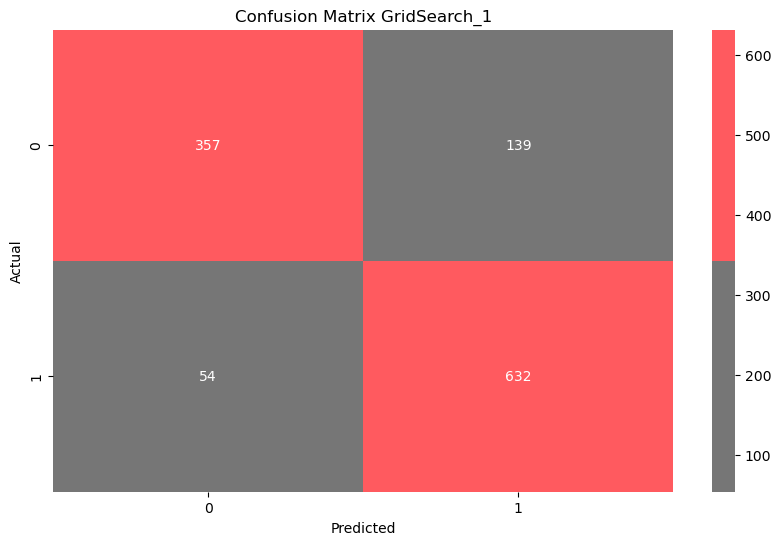

In [70]:
# Test data predictions 
y_pred_grid1 = fittedgrid_1_bow_collapsed.best_estimator_.predict(X_test_ct_bow)

# Compute Confusion Matrix
Confusion_Matrix_grid1 = confusion_matrix(y_test, y_pred_grid1)

# Define the colors in hex format
colors_hex = ['#767676', '#FF5A5F']

# Create a colormap using ListedColormap
custom_cmap = ListedColormap(colors_hex)

# Determine plot size
plt.figure(figsize=(10, 6))

# Plot confusion matrix heatmap
sns.heatmap(Confusion_Matrix_grid1, annot=True, cmap = custom_cmap, fmt='d')

# Add labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix GridSearch_1')

plt.show()

#### GridSearch_1 Classification Report

In [71]:
# Show best model test data classification report
print(classification_report(y_test, y_pred_grid1))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79       496
           1       0.82      0.92      0.87       686

    accuracy                           0.84      1182
   macro avg       0.84      0.82      0.83      1182
weighted avg       0.84      0.84      0.83      1182



### GridSearch_1 Result Summary

The main procedure we took for this first GridSearch is the same as we used in the previous notebook: We vectorized the dataset using two text vectorizer tools, then by comparing each cross-validation score with different combinations of hyperparameters on the models we selected, we managed to find the best model giving the highest F1 score. The result is significantly different than what we obtained with the previous dataset. Our best model selected is a **Logistic Regression** model with a penalty hyperparameter **'C'** equals to 0.001. After plotting a confusion matrix and extracting a classification report, we are able to summarize the following findings:

- As our dataset is much smaller than the one we analyzed in the previous notebook, our best model prediction score on the testing data decreases to **86.75%** with a still high training score of **96.08%**. This indicates slight overfitting and might also be because we obtained a relatively small testing dataset.
- Based on the confusion matrix, we observe that our model can predict outstanding listings with only **54** misclassified, but misclassified **139** less-outstanding listings as outstanding. Additionally, from the statistics in the classification report, we observe that our model achieved a **92%** recall score for outstanding listings but a **72%** recall score for less-outstanding listings.

Our next step is to include **Random Forest Classifier** aiming at improving our model performance. Additionally, for better interpretability, we will utilize **n-grams** in our text vectorizing stage and remove single-word tokens.

***

## GridSearch_2 : Ngrams

After the first grid search, we obtained more focused parameter ranges and a currently best performed **Logistic Regression** model. Our next step is to aim for better interpretability and hopefully further enhance our model performance by adding n-grams to the vectorizer. N-grams are essentially pairs of consecutive words that help maintain the sequence and interpretability of the tokens. In our second grid search, we will use bigrams (2 words), trigrams (3 words), and remove single words for both the bag-of-words vectorizer and the TF-IDF vectorizer.

|    Models   |    Hyperparameters   |   Ranges/Options  |
|:-------------:|:-------------:|:-------------:|
|    **TF-IDF Vectorizer**     |     max_df   |    0.95     |
|                  |     min_df  |    5       |
|                  |     N_grams  |    bigrams, trigrams       |
|       **Bag of Words CountVectorizer**           |     max_df  |    0.95       |
|                  |     min_df  |    5       |
|                  |     N_grams  |    bigrams, trigrams       |
|    **Logistic Regression**     |    C     |    0.001, 0.01, 0.1, 1, 10    |
|         |    penalty     |     'l2'     | 
|    **Decision Tree Classifier**     |     max_depth    |     2, 4, 8    |
|                 |    min_samples_leaf     |     2, 4, 8    |
|                 |     min_samples_split    |     2, 4, 8    |
|                 |     criterion    |     'gini', 'entropy'    |
|    **Random Forest Classifier**     |    n_estimators     |     5, 10, 15    |
|                 |     max_depth    |     2, 4, 8    |
|                 |     min_samples_leaf    |     2, 4, 8    |
|                 |     criterion    |     'gini', 'entropy'    |

### Second GridSearch
Run time: 6h 54min 51s

In [23]:
# # Second GridSearch
#-----------------------------------------------------------------------------------------------------------------#
# Define column transformers with ngrams added
ct_bow_ngrams = define_col_trans('ct_bow',  CountVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer, ngram_range=(2, 3)))
ct_tfidf_ngrams = define_col_trans('ct_tfidf',  TfidfVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer, ngram_range=(2, 3)))
#-----------------------------------------------------------------------------------------------------------------#
# Fit and transform on training data using new vectorizers
print('Transforming training sample data .....')
X_train_ct_bow_ngrams = ct_bow_ngrams.fit_transform(X_train)
X_train_ct_tfidf_ngrams= ct_tfidf_ngrams.fit_transform(X_train)
print('Training sample data transformed.')
#-----------------------------------------------------------------------------------------------------------------#

# If one needs to retrain the model, set loading flag as False
loaded_flag_2 = True

if loaded_flag_2:
    print('Loaded pre-trained models (Gridsearch_2)')
    # Load saved fittedgrid
    fittedgrid_2_bow_collapsed=joblib.load('data/fittedgrid_2_bow_collapsed.pkl')
    fittedgrid_2_tfidf_collapsed=joblib.load('data/fittedgrid_2_tfidf_collapsed.pkl')
else:

    # Define base pipeline
    pipeline_2 = Pipeline([
        ('sparse_to_dense', FunctionTransformer(convert_to_array, accept_sparse=True)),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])

    # Instantiate Pipeline with grid of parameters
    grid_param_2 = [
        
        # Logistic Regression
        {
            'model'              : [LogisticRegression()],
            'model__C'           : [0.001, 0.01, 0.1, 1, 10], # C parameter to control penalty weights
            'model__penalty'     : ['l2'], # Control penalty types, l1: Lasso, l2: Ridge
            'model__random_state': [123], # Control gradient descent starting point
            'model__max_iter'    : [10000] # Make sure model iterates
        },

        # Decision Tree Classifier
        {
            'model'                   : [DecisionTreeClassifier()],
            'model__max_depth'        : [2, 4, 8], # Control number of tree splits/depth
            'model__min_samples_leaf' : [2, 4, 8], # Control minimum number of samples at a leaf node
            'model__min_samples_split': [2, 4, 8], # Control minimum number of samples split at a leaf node
            'model__criterion'        : ['gini'], # Control the function to measure the quality of a split
            'model__random_state'     : [123] # Control randomness of the estimator
        },

        # Random Forest
        {
            'model'                   : [RandomForestClassifier()],
            'model__n_estimators'     : [5, 10, 15], # Control number of trees in the forest
            'model__max_depth'        : [2, 4, 8], # Control number of tree splits/depth
            'model__min_samples_leaf' : [2, 4, 8], # Control minimum number of samples at a leaf node
            'model__criterion'        : ['gini', 'entropy'], # Control the function to measure the quality of a split
            'model__random_state'     : [123] # Control randomness of the estimator  
        }  
    ]

    # Use GridSearch
    grid_2 = GridSearchCV(estimator=pipeline_2, # Define GridSearch estimator pipeline
                         param_grid=grid_param_2, # Define parameter grid
                         cv=5, # Define 5-fold cross-validation
                         n_jobs=-2,
                         scoring='f1') # Define GridSearch evaluation metric to be f1 score

    # Fit the grid on training data
    fittedgrid_2_bow_collapsed = grid_2.fit(X_train_ct_bow_ngrams, y_train)
    fittedgrid_2_tfidf_collapsed = grid_2.fit(X_train_ct_tfidf_ngrams, y_train)
    
    # Save fittedgrid as pickle file
    joblib.dump(fittedgrid_2_bow_collapsed, 'data/fittedgrid_2_bow_collapsed.pkl')
    joblib.dump(fittedgrid_2_tfidf_collapsed, 'data/fittedgrid_2_tfidf_collapsed.pkl')

Transforming training sample data .....
Training sample data transformed.
Loaded pre-trained models (Gridsearch_2)


***

### Second GridSearch Results

In [24]:
print('\n--------------------\n')
print(fittedgrid_2_bow_collapsed.best_estimator_)

# Print Crossvalidated Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_2_bow_collapsed.score(X_train_ct_bow_ngrams, y_train)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')

# Vectorize on testing data to evaluate model actual performance
X_test_ct_bow_ngrams = ct_bow_ngrams.transform(X_test)
print(f'Best Model Test Score (%): {round(fittedgrid_2_bow_collapsed.score(X_test_ct_bow_ngrams, y_test)*100, 2)}') 


--------------------

Pipeline(steps=[('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_array at 0x0000023E169A6340>)),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.001, max_iter=10000,
                                    random_state=123))])

--------------------

Best Model Train Score (%): 100.0

--------------------

Best Model Test Score (%): 83.13


In [25]:
print('\n--------------------\n')
print(fittedgrid_2_tfidf_collapsed.best_estimator_)

# Print Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_2_tfidf_collapsed.score(X_train_ct_tfidf_ngrams, y_train)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')

# Vectorize on testing data to evaluate model actual performance
X_test_ct_tfidf_ngrams = ct_tfidf_ngrams.transform(X_test)
print(f'Best Model Test Score (%): {round(fittedgrid_2_tfidf_collapsed.score(X_test_ct_tfidf_ngrams, y_test)*100, 2)}') 


--------------------

Pipeline(steps=[('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_array at 0x0000023E169A6340>)),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.001, max_iter=10000,
                                    random_state=123))])

--------------------

Best Model Train Score (%): 100.0

--------------------

Best Model Test Score (%): 83.69


#### Top 10 models with best F1 scores resulted with TF-IDF transformed data

In [106]:
# Expand column width to see full results
pd.set_option('display.max_colwidth', None)

# Store results in a dataframe by sorting mean_test_score in descending order
fittedgrid2_results_df = pd.DataFrame(fittedgrid_2_tfidf_collapsed.cv_results_).sort_values('mean_test_score', ascending=False)

# Extract ranking number, models with tuned hyperparameters, and corresponding test scores
fittedgrid2_results = fittedgrid2_results_df[['rank_test_score', 'params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)
print('GridSearch_2 Cross_Validation Results')

# Show top 10 cross validation results
fittedgrid1_results.head(10) 

GridSearch_2 Cross_Validation Results


,rank_test_score,params,mean_test_score
1,1,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 0.001, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.835450
3,2,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 0.01, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.823902
5,3,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 0.1, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.817805
7,4,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 1, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.811765
9,5,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 10, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.810164
15,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 4, 'model__min_samples_split': 8, 'model__random_state': 123}",0.788766
10,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.788766
13,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__random_state': 123}",0.788766
11,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.788766
16,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 8, 'model__min_samples_split': 2, 'model__random_state': 123}",0.788766


#### GridSearch_2 Best Model Confusion Matrix

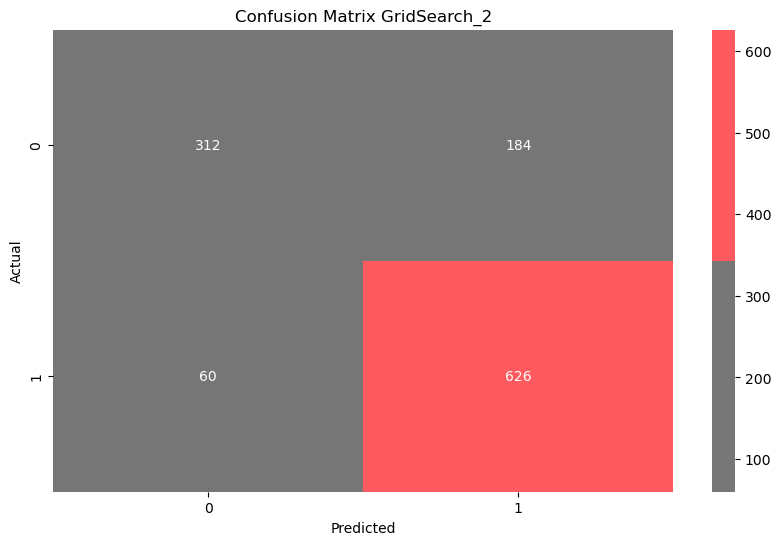

In [107]:
# Test data predictions 
y_pred_grid2 = fittedgrid_2_tfidf_collapsed.best_estimator_.predict(X_test_ct_tfidf_ngrams)

# Compute Confusion Matrix
Confusion_Matrix_grid2 = confusion_matrix(y_test, y_pred_grid2)

# Define the colors in hex format
colors_hex = ['#767676', '#FF5A5F']

# Create a colormap using ListedColormap
custom_cmap = ListedColormap(colors_hex)

# Determine plot size
plt.figure(figsize=(10, 6))

# Plot confusion matrix heatmap
sns.heatmap(Confusion_Matrix_grid2, annot=True, cmap = custom_cmap, fmt='d')

# Add labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix GridSearch_2')

plt.show()

#### GridSearch_2 Classification Report

In [76]:
# Show best model test data classification report
print(classification_report(y_test, y_pred_grid2))

              precision    recall  f1-score   support

           0       0.84      0.63      0.72       496
           1       0.77      0.91      0.84       686

    accuracy                           0.79      1182
   macro avg       0.81      0.77      0.78      1182
weighted avg       0.80      0.79      0.79      1182



### GridSearch_2 Result Summary

The results from the second GridSearch provided us with some interesting insights. After utilizing n-grams in the text vectorizing stage, our model seems to underperform compared to the best model selected from the previous GridSearch. Our selected model is still the **Logistic Regression model** with a penalty hyperparameter **'C'** equal to **0.001**. After plotting the confusion matrix and extracting statistics from the classification report, we are able to derive the following findings:

- During this GridSearch, we utilized n-grams for better model interpretability. However, the current best model underperformed with an F1 score of **83.69** compared to the model from GridSearch_1 (**86.75%**). Considering that the model itself and its corresponding hyperparameters are all the same, we conclude that including n-grams confuses the model, possibly due to the presence of massive blocks of text in each data point. Furthermore, we observe that the training score is **100%** suggesting strong evidence of **overfitting**.
- Based on the classification report, we see that the **recall** score for predicting **outstanding** listings remains pretty good at **91%**, while the recall score for predicting **less-outstanding** listings decreases to **63%**. This indicates that it becomes more difficult for our model to decide if a listing is less-outstanding (Overall Star Rating < 4.8). This can be further seen in the confusion matrix. We misclassified only **60** less-outstanding listings as outstanding, which is about the same performance compared to the previous model. However, we misclassified **184** less-outstanding listings as outstanding. This further proves that condensed reviews contain a mixture of feedback from guests, and we need more data for our model to successfully capture specific indicators.

***

## Summary

We eventually conducted two grid searches and obtained the following modeling results. The results, including the selected model hyperparameters, will be presented in a dataframe below.

Our next step is to use our current findings including fine-tuned model parameter ranges and model selections to perform more specific analysis on what could potentially be the indicators for outstanding listings defined on different subratings. Furthermore, based on the analsyis in this notebook, we decide to proceed with the uncollapsed dataset for analysis since it provides more datapoints hence helps our model to make predictions and prevent overfitting. 

In [81]:
# Review Collapsed Reviews Modelling Results
fittedgrid_results_collapsed = [['Dummy','Dummy Classifier' ,'','', round(accuracy_score(y_test, y_predict_d)*100, 2)],
                   ['GridSearch_1_General_Sweep', 
                    fittedgrid_1_tfidf_collapsed.best_estimator_, 
                    round(fittedgrid_1_bow_collapsed.score(X_train_ct_bow, y_train)*100.00, 2),
                    round(fittedgrid_1_tfidf_collapsed.score(X_train_ct_tfidf, y_train)*100.00, 2), 
                    round(fittedgrid_1_bow_collapsed.score(X_test_ct_bow, y_test)*100.00,2)],
                   ['GridSearch_2_N_grams', 
                    fittedgrid_2_tfidf_collapsed.best_estimator_, 
                    round(fittedgrid_2_bow_collapsed.score(X_train_ct_bow_ngrams, y_train)*100.00, 2), 
                    round(fittedgrid_2_tfidf_collapsed.score(X_train_ct_tfidf_ngrams, y_train)*100.00, 2),
                    round(fittedgrid_2_tfidf_collapsed.score(X_test_ct_tfidf_ngrams, y_test)*100.00,2)]]



fittedgrid_df_collapsed = pd.DataFrame(fittedgrid_results_collapsed, columns = ['Modelling Title', 
                                                                                    'Best_Estimator', 
                                                                                    'Best_Bow_Transformed_Training_Score', 
                                                                                    'Best_TF_IDF_Transformed_Training_Score',
                                                                                    'Best_TF_IDF_Transformed_Testing_Score'])

In [101]:
# Show all estimator parameters
pd.set_option('display.max_colwidth', 1000)

# Show dataframe
fittedgrid_df_collapsed

,Modelling Title,Best_Estimator,Best_Bow_Transformed_Training_Score,Best_TF_IDF_Transformed_Training_Score,Best_TF_IDF_Transformed_Testing_Score
0,Dummy,Dummy Classifier,,,58.04
1,GridSearch_1_General_Sweep,"(FunctionTransformer(accept_sparse=True,\n func=<function convert_to_array at 0x0000023E169A6340>), StandardScaler(), LogisticRegression(C=0.001, max_iter=10000, random_state=123))",96.08,99.57,86.75
2,GridSearch_2_N_grams,"(FunctionTransformer(accept_sparse=True,\n func=<function convert_to_array at 0x0000023E169A6340>), StandardScaler(), LogisticRegression(C=0.001, max_iter=10000, random_state=123))",100.0,100.0,83.69
